# LOSC Data Quickview (Linear Spectrogram)

Welcome! This IPython notebook provides a quick look at short segments of data from the <a href='https://losc.ligo.org/'>LIGO Open Science Center</a>

* Set the GPS time (t0) and data set in the first cell
* Click "Run All" in the cell menu at the top
* Your plots will appear at the <a href='#PSD,-Whitened-Data,-and-Spectrogram'>bottom of the page</a>.

v0.4; November 2016

## Set GPS time and data set
Example GPS times for <a href='https://losc.ligo.org/s6hwcbc/'>S6 Hardware Injections</a>

In [1]:
# t0 = 933661015.0  # Time of a successful s6 hardware injection in H1 (SNR 140)
t0 = 968654557.955 # Time of big dog (S6 blind injection)
dataset = 'S6'
detector = 'H1'
version = 'V1'  # V1 is "version 1" of the data release

## Download the data file
See also <a href='https://losc.ligo.org/tutorial_get_data2/'>this download tutorial.</a>

In [2]:
import json
import urllib2

observatory = detector[0]         # first letter of the detector H or L
hour        = int(t0)&0xFFFFF000  # the filename rounding down to a multiple of 4096
fortnight   = int(t0)&0xFFF00000  # the directory by rounding down to multiple of 4096*256
filename = '{0}-{1}_LOSC_4_{2}-{3}-4096.hdf5'.format(observatory, detector, version, hour)
urlformat = 'https://losc.ligo.org/archive/data/{0}/{1}/{2}'
url = urlformat.format(dataset, fortnight, filename)

# -- Uncomment these 3 lines to run this notebook on GW150914 instead!
#t0 = 1126259462.43 # GW150914
#url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
#filename = url.split('/')[-1]

In [3]:
print('Downloading ' + url + '  (this might take a few minutes...)')
r = urllib2.urlopen(url).read()
f = open(filename, 'w')   # write it to the right filename
f.write(r)
f.close()
print("File download complete")

File download complete


## Import some python modules

In [4]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

# LIGO-specific readligo.py 
import readligo as rl

**NOTE** Watch out for data gaps! See notes on the LOSC website, for example here: https://losc.ligo.org/segments/

## Load data

In [5]:
strain, time, chan_dict_H1 = rl.loaddata(filename, 'H1')

# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

print("Got a sample frequency of {0}".format(fs))
print ("Found {0} seconds of data".format(strain.size*dt))

Got a sample frequency of 4096
Found 4096.0 seconds of data


## Calculate the ASD

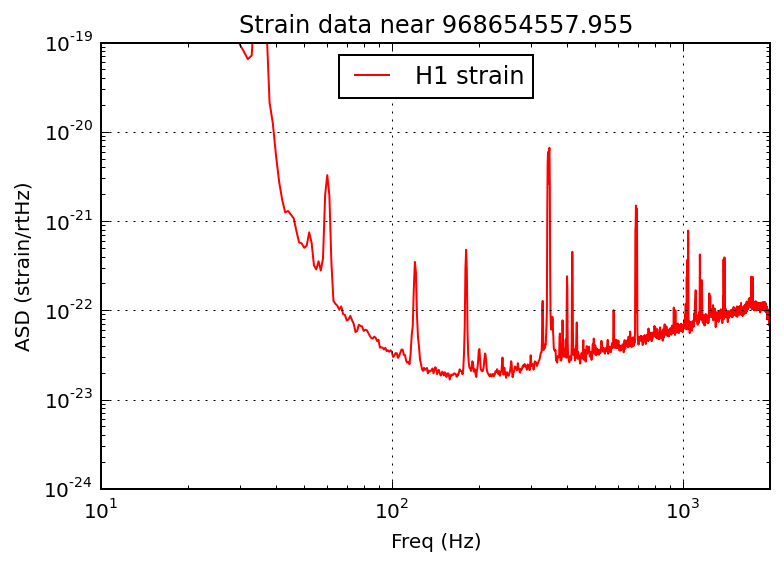

In [6]:
#-- How much data to use for the ASD?
deltat = 15  # Number of seconds on each side of data
N_samp = deltat*fs

# -- Center the ASD segment on the requested time
indx = np.where(np.abs(rel_time) < dt)[0][0]

strain_seg = strain[indx-N_samp : indx+N_samp]
time_seg = rel_time[indx-N_samp : indx+N_samp]

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT))

# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, Pxx)

# plot the ASDs:
fig1 = plt.figure()
plt.loglog(freqs, np.sqrt(Pxx),'r',label='{0} strain'.format(detector))
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Strain data near {0}'.format(t0))
plt.savefig('asd.png')

## Whiten the data

In [7]:
# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht
# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

## Band-pass the data

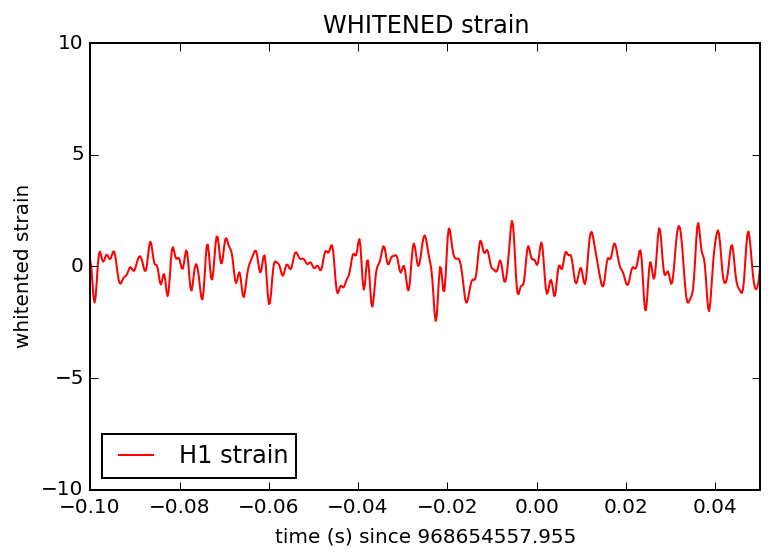

In [8]:
# We need to suppress the high frequencies with some bandpassing:
high_freq = 600.
low_freq  = 30.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)

fig2 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-0.1,0.05])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')
plt.savefig('strain_whitened.png')

## Spectrogram

[-0.5, 0.5, 0, 700]

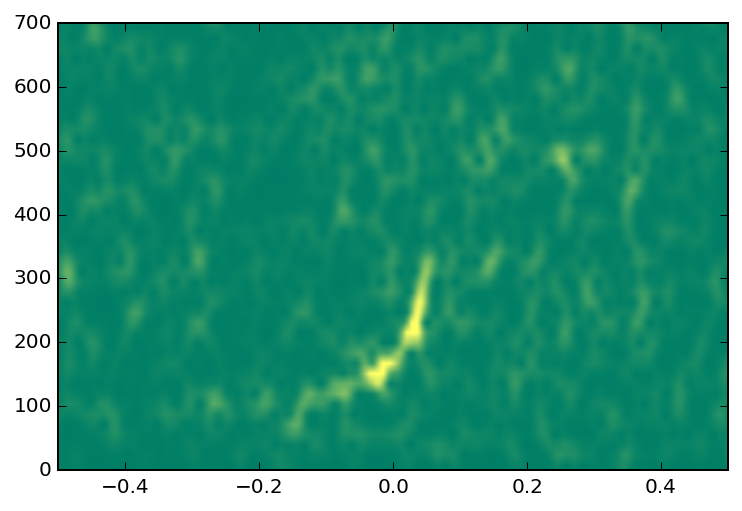

In [9]:
# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15./16)
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# spec_cmap='viridis'
spec_cmap='summer' 

# Calculate the whitened spectrogram
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_whiten, NFFT=NFFT, Fs=fs, window=window, 
      noverlap=NOVL, xextent=[-deltat,deltat], cmap=spec_cmap, vmin=0, vmax=0.01, scale='linear')
plt.axis([-0.5, 0.5, 0, 700])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


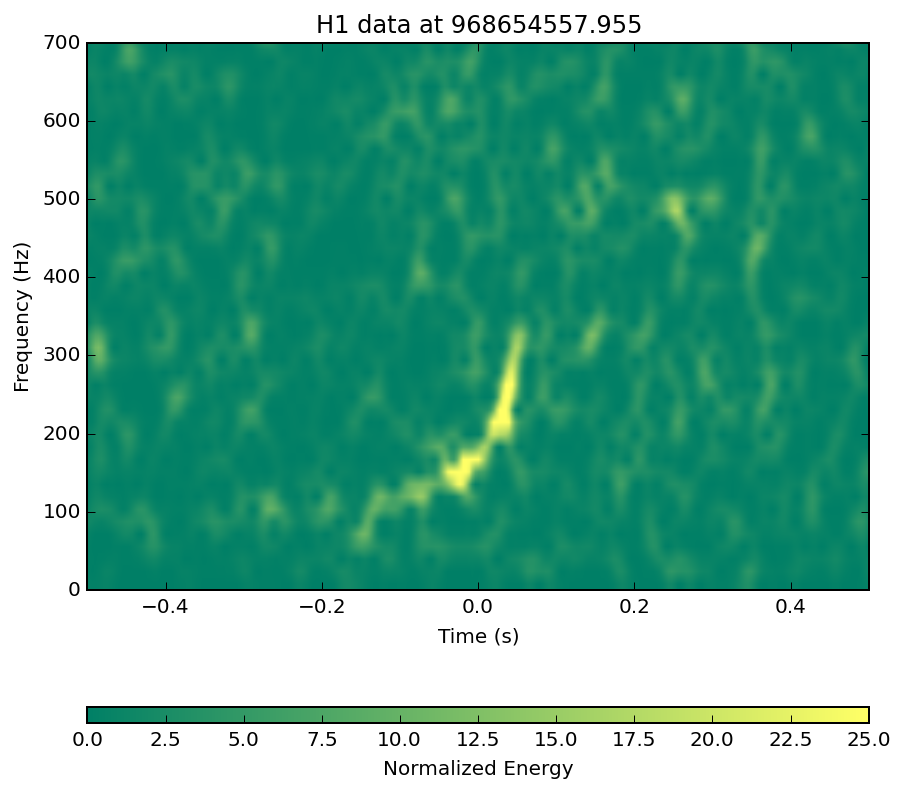

In [10]:
# -- Normalize the Spectrogram, and re-plot it with conventions that mimic Omega Pipeline
fig3, ax = plt.subplots(figsize=(7,7))
Z = np.flipud(spec_H1) / np.median(spec_H1)
extent = -deltat, deltat, freqs[0], freqs[-1]
im = ax.imshow(Z,  cmap=spec_cmap, extent=extent, vmin=0, vmax=25)
ax.axis('auto')
fig3.colorbar(im, ax=ax, orientation='horizontal', label='Normalized Energy', aspect=50)
plt.axis([-0.5, 0.5, 0, 700])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('{ifo} data at {t0}'.format(ifo=detector, t0=t0))

## PSD, Whitened Data, and Spectrogram

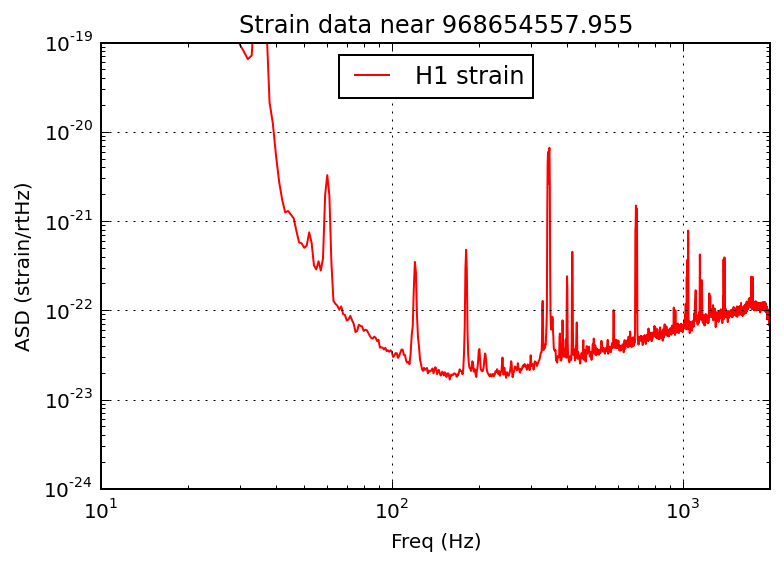

In [11]:
fig1

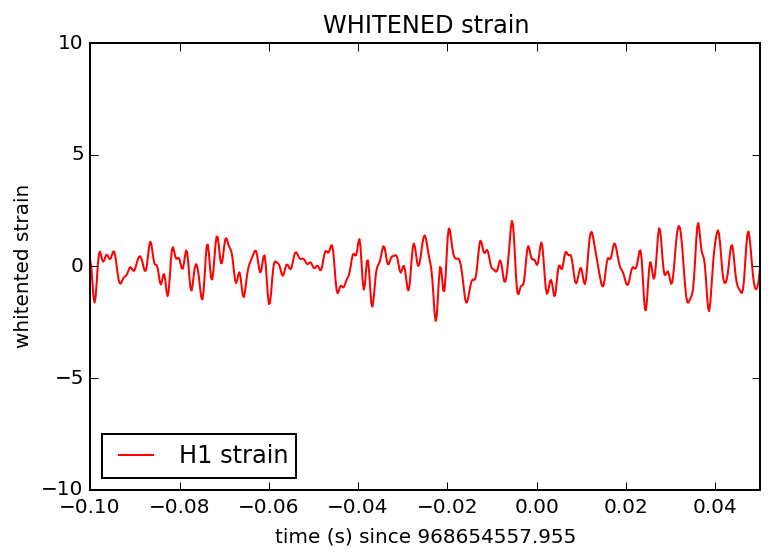

In [12]:
fig2

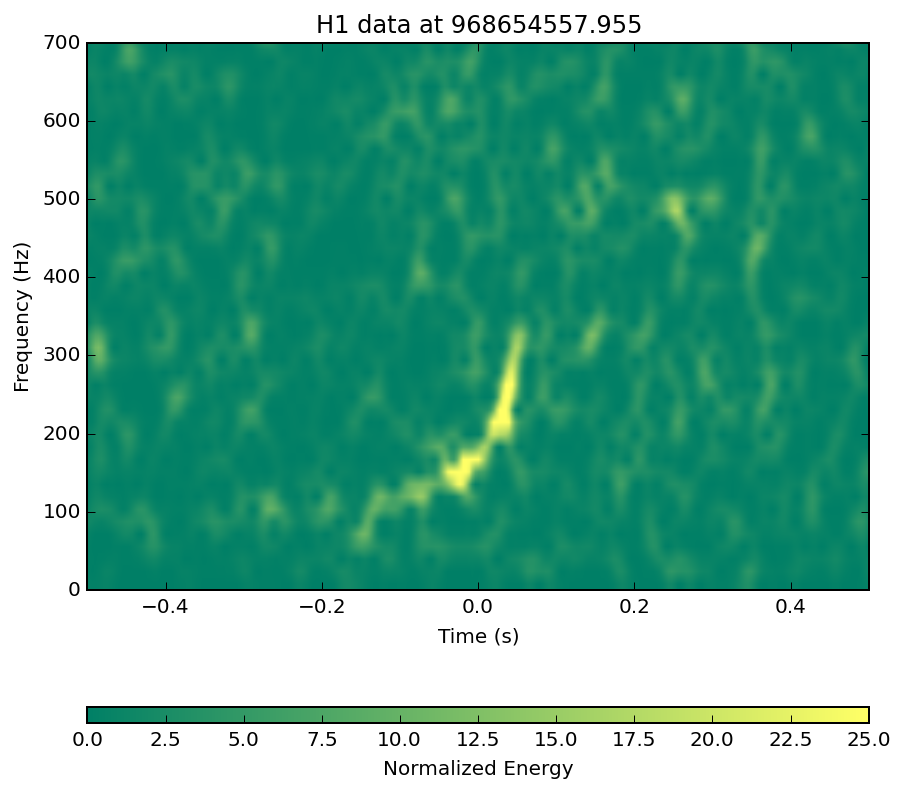

In [13]:
fig3